# Pneumothorax demo

This demo exists to show some additional functionality of misas and to demonstrate that it is applicable to non MRI data. In this case chest X-rays.
This demo is a variation of the one shown in the fastai 2 docs where the dataset is used for classification. We use it to do segmentation.

> Warning:
We will massively overfit the data just to showcase some functionality. The resulting model is not suitable for productive usage at all.

In [ ]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
%cd misas

In [ ]:
from fastai2.vision.all import *
from fastai2.medical.imaging import *

In [ ]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

In [ ]:
pneumothorax_source.ls()

(#2) [Path('/home/ankenbrand/.fastai/data/siim_small/train'),Path('/home/ankenbrand/.fastai/data/siim_small/labels.csv')]

In [ ]:
items = get_dicom_files(pneumothorax_source/f"train/")

In [ ]:
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


In [ ]:
df_pneumo = df[df['label']=='Pneumothorax']

In [ ]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), MaskBlock(codes=['bg','pneumo'])),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   get_y=lambda x:'example/siim/'+Path(x[0]).stem+'.png',
                   batch_tfms=aug_transforms(do_flip=False,p_affine=0,p_lighting=0,size=224))

dls = pneumothorax.dataloaders(df_pneumo.values, num_workers=0, bs=16)

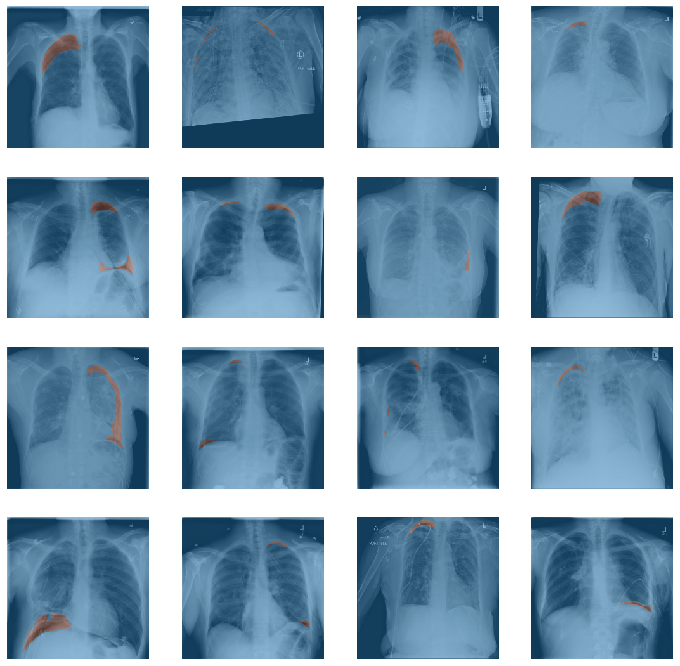

In [ ]:
dls.show_batch(max_n=16, vmin=0)

In [ ]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,0.812611,0.187562,00:32


epoch,train_loss,valid_loss,time
0,0.149961,0.141925,00:24
1,0.124823,0.165697,00:26
2,0.109837,0.127106,00:25
3,0.100992,0.109888,00:25
4,0.092955,0.084459,00:25
5,0.085330,0.083218,00:25
6,0.078563,0.098375,00:26
7,0.073070,0.101087,00:25


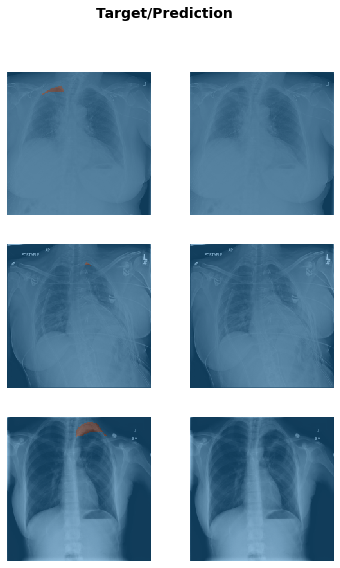

In [ ]:
learn.show_results(ds_idx=0,max_n=9,vmin=0)

In [ ]:
preds = learn.get_preds(ds_idx=0)

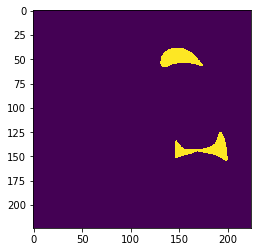

In [ ]:
plt.imshow(preds[1][2])

In [ ]:
preds[0].argmax(dim=1).sum()
#plt.imshow(preds[0].argmax(dim=1)[0])

tensor(0)

In [ ]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,0.071965,0.525467,00:32


epoch,train_loss,valid_loss,time
0,0.331804,0.099155,00:24
1,0.225997,0.096656,00:24
2,0.171982,0.092713,00:24
3,0.138067,0.082533,00:24
4,0.116257,0.132873,00:26
5,0.100806,0.101615,00:25
6,0.089429,0.174734,00:24
7,0.080170,0.173476,00:28


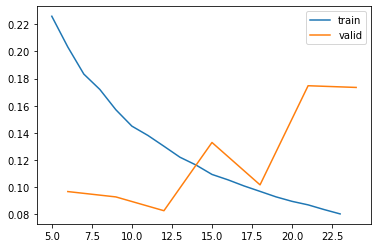

In [ ]:
learn.recorder.plot_loss()

In [ ]:
preds = learn.get_preds(ds_idx=0)
preds[0].argmax(dim=1).sum()

tensor(0)

tensor(0.1590)
tensor(0.3747)
tensor(0.2383)
tensor(0.2284)
tensor(0.3874)


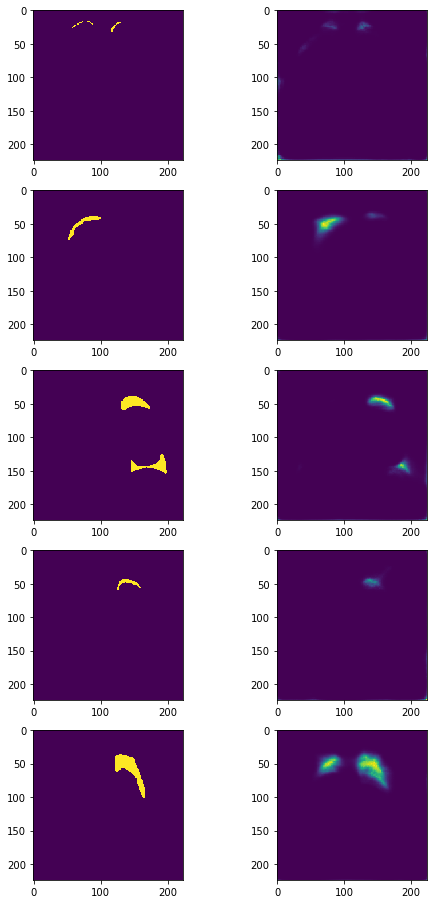

In [ ]:
fig, axs = plt.subplots(5,2,figsize=(8,16))
for i in range(5):
    axs[i,0].imshow(preds[1][i])
    axs[i,1].imshow(preds[0][i][1])
    print(preds[0][i][1].max())

In [ ]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,time
0,0.030432,0.153031,00:26
1,0.031023,0.105601,00:31
2,0.048796,0.081914,00:42
3,0.053467,0.403500,00:25
4,0.049546,0.170542,00:25
5,0.048739,0.161988,00:24
6,0.046755,0.171562,00:24
7,0.045395,0.145385,00:25


In [ ]:
preds = learn.get_preds(ds_idx=0)
preds[0].argmax(dim=1).sum()

tensor(0)

In [ ]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,time
0,0.038203,0.137219,00:23
1,0.035769,0.158161,00:23
2,0.033682,0.191132,00:24
3,0.032657,0.254799,00:27
4,0.030958,0.278088,00:27
5,0.029972,0.173968,00:30
6,0.029445,0.131165,00:28
7,0.029038,0.111202,00:26
8,0.028115,0.229451,00:25
9,0.027331,0.123636,00:27


In [ ]:
preds = learn.get_preds(ds_idx=0)
preds[0].argmax(dim=1).sum()

tensor(42287)

tensor(0.7736)
tensor(0.9046)
tensor(0.9997)
tensor(0.9525)
tensor(0.9696)


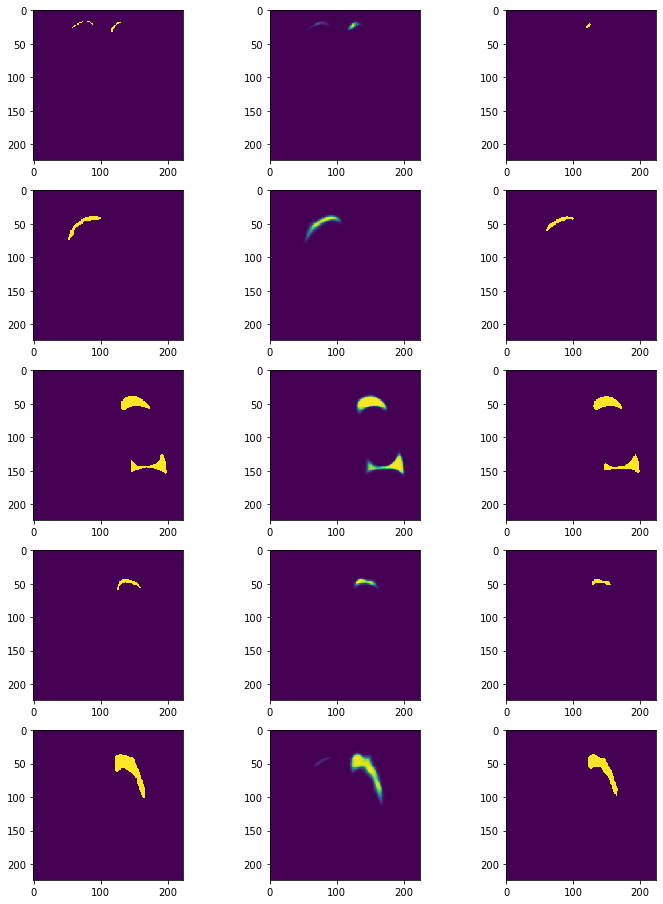

In [ ]:
fig, axs = plt.subplots(5,3,figsize=(12,16))
for i in range(5):
    axs[i,0].imshow(preds[1][i])
    axs[i,1].imshow(preds[0][i][1])
    axs[i,2].imshow(preds[0].argmax(dim=1)[i])
    print(preds[0][i][1].max())

### We managed to overfit

In [ ]:
from misas.core import *
from fastai.vision import open_mask, Image, ImageSegment
import pydicom

In [ ]:
def read_dcm(fname):
    dcm = fname.dcmread()
    pixels = dcm.pixels.unsqueeze(0)
    pixels = torch.cat((pixels,pixels,pixels), dim=0)
    return Image(pixels/255)

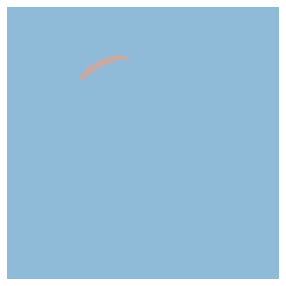

In [ ]:
learn.predict(learn.dls.train_ds.items[1])[0].show(vmin=0)

In [ ]:
fname = df_pneumo.iloc[3]['file']
img = lambda: read_dcm(pneumothorax_source/fname)
trueMask = lambda: open_mask('example/siim/'+Path(fname).stem+'.png')

In [ ]:
dcm = img()

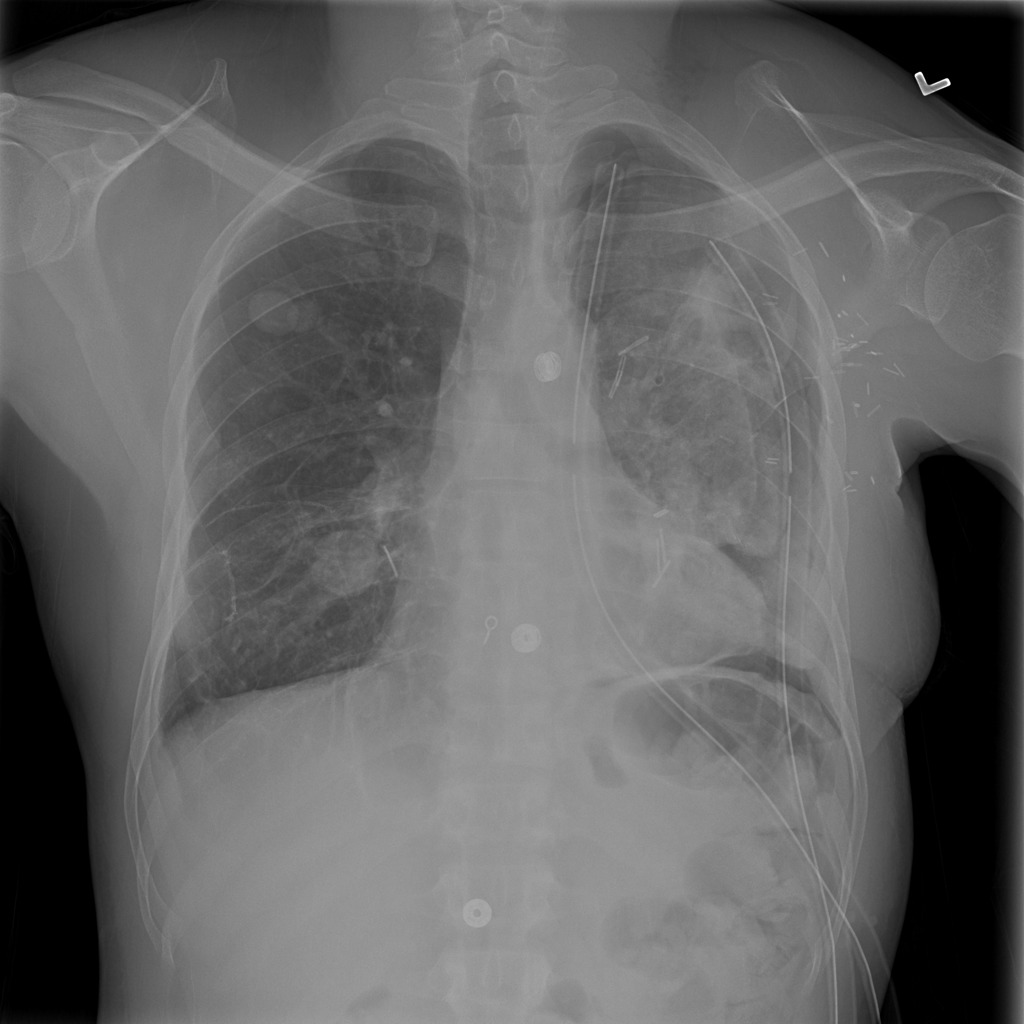

In [ ]:
to_image(dcm.data)

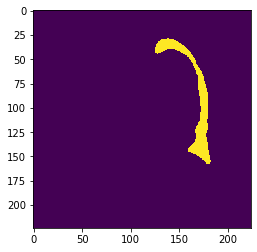

In [ ]:
plt.imshow(learn.predict(PILDicom(to_image(dcm.data)))[1])

In [ ]:
class Fastai2_wrapper:
    def __init__(self, model):
        self.model = model
        self.model.cbs = []
    
    def imageToPILDicom(self, image):
        return PILDicom(to_image(image.data))
    
    def prepareSize(self, imageOrMask):
        return imageOrMask.clone().resize(224)
    
    def predict(self, image):
        in_image = self.imageToPILDicom(image)
        pred = self.model.predict(in_image, )
        return (ImageSegment(pred[1].unsqueeze(0)),)

In [ ]:
model = Fastai2_wrapper(learn)

In [ ]:
model.predict(img())

(ImageSegment (1, 224, 224), Image (3, 1024, 1024))

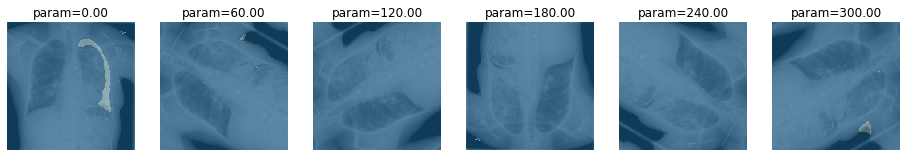

In [ ]:
plot_series(get_rotation_series(img(), model))

In [ ]:
result = eval_rotation_series(img(), trueMask(), model, start=-180, end=180, components=['bg','pneumo'])

/home/ankenbrand/miniconda3/envs/misas/lib/python3.7/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


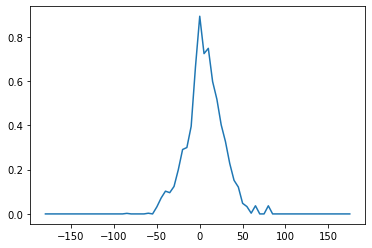

In [ ]:
plt.plot(result['deg'],result['pneumo'])